# Parallelizing Code with the built-in ```multiprocessing``` module.

First, let's create a single-threaded function that is conducive to being multithreaded:

In [6]:
import numpy as np
import time 


def GenerateData_Singlethread(procnum, NumElems, return_dict):
    """
    generates a simple function of the integers from (procnum)*NumElems to (procnum)*NumElems-1
    The output is passed by reference to return_dict
    """
    A = np.arange( (procnum)*NumElems, (procnum+1)*NumElems)                  
    return_dict[procnum] = np.cos(A/50000.0)-1.3*np.cos(A*2.0/50000.0)

And here is the magic happens:

In [19]:
from multiprocessing import Pool, Process
import multiprocessing

NumThreads = 4

NumSamples = 5*(10**6)
                  
                  
tic = time.time()  # start timer - benchmark how much faster the multithreaded version over the single threaded


TotalElems = 0
manager = multiprocessing.Manager()
return_dict = manager.dict()  
#just a pointer - dict() is where we shall store 
#the values generated by the function in each process


jobs = []


NumElemsInEachThread = [] # record the number of elements we will generate in each thread
for k in range(NumThreads):
    p = multiprocessing.Process(target=GenerateData_Singlethread, 
                                args=(k, int(np.ceil(NumSamples/NumThreads)),return_dict, )
                               )
    #create a process, and call the target function with each Process 
    # the arguments of each function call are given in the form of a tuple
    NumElemsInEachThread.append( int(np.ceil(NumSamples/NumThreads)) )
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()  # wait until each process has halted before continuing

print('Elapsed Time after running all threads = %2.2f sec'%(time.time()-tic))    






Elapsed Time after running all threads = 1.57 sec


Now that all the functions have been run, we will need to retrieve the data from the ```return_dict```.

In [8]:
#now combine the data
tic = time.time()    

TotalElems = np.sum(NumElemsInEachThread)

DataAll = np.zeros((TotalElems,)) # create an empty vector (or a matrix) the size of the total data

OrderOfExecution = np.flip(return_dict.keys()) 
# outputs of functions are stored in a stack in return_dict
# .keys() gives the order in which each process was completed and pushed into the stack
# when we pop each of them out, they would be in reverse order, hence the np.flip() command

for k in (OrderOfExecution):
    DataAll[ int(np.sum(NumElemsInEachThread[0:k])):int(np.sum(NumElemsInEachThread[0:(k+1)]))] = \
    return_dict.popitem()[1]

#once we have popped everything from the stack,  running return_dict.popitem()[1]  again will result in an error:

try:
    return_dict.popitem()[1]
except:    
    print('Could not pop item from return_dict anymore')

    
print(DataAll)

print('Parts Assignment: %2.2f sec'%(time.time()-tic))

print(DataAll.shape)



Could not pop item from return_dict anymore
[-0.3        -0.3        -0.3        ...  0.22908075  0.22904546
  0.22901018]
Parts Assignment: 0.18 sec
(5000000,)


Text(0.5, 1.0, 'Multithreaded output')

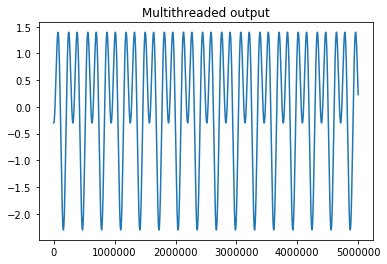

In [9]:
import matplotlib.pyplot as plt

plt.plot(DataAll)
plt.title('Multithreaded output')

What happens when we run the single thread instead?

Elapsed Time (single-threaded) = 0.27 sec
(5000000,)


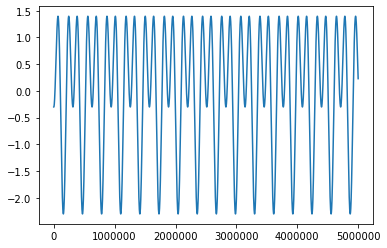

In [10]:

procnum2 = 0
NumElems2 = NumSamples

tic = time.time()
PassByRefArr= [np.zeros((NumElems2,1))]
GenerateData_Singlethread(procnum= procnum2, NumElems = NumElems2, return_dict = PassByRefArr)

print('Elapsed Time (single-threaded) = %2.2f sec'%(time.time()-tic))

print(PassByRefArr[0].shape)

plt.plot(PassByRefArr[0])

Single-threaded took 0.27 sec.  

Multi-threaded toook 1.6 sec.  

Bottom line: Use multithreading judiciously; it may only offer a speed-up in some cases.  